In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import tensorflow
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from sklearn import preprocessing
import math

# Data Preprocessing

In [4]:
csv_file = "denser_data_collection.csv" #"denser_data_collection_marker.csv" #"data_collection.csv"
columns = ['Serial_no','Timestamp', 'x_actual', 'y_actual', 'direction', 'x_step', 'y_step']
data_df = pd.read_csv(csv_file, header=None, names = columns)

serial_numbers = data_df['Serial_no'].astype(str).apply(lambda x: int(x.split(',')[0]))

image_folder = "output_images_denser" #"output_images_denser_marker" #"cropped_noedges_new" #"output_images_new" #"images_resized_500"


le = preprocessing.LabelEncoder()
data_df['direction'] = le.fit_transform(data_df['direction'])


count_direction_0 = data_df[data_df['direction'] == 0].shape[0]
count_direction_1 = data_df[data_df['direction'] == 1].shape[0]


print("Number of rows with direction 0:", count_direction_0)
print("Number of rows with direction 1:", count_direction_1)



serial_numbers = set(data_df['Serial_no'])
date_time = data_df['Timestamp']
x_coordinate = data_df['x_actual']
y_coordinate = data_df['y_actual']
direction = data_df['direction']
x_step = data_df['x_step']
y_step = data_df['y_step']


image_files = os.listdir(image_folder)

X = []  # Image data
Y = []  # Labels (contact: 1, non-contact: 0, sus_data: 2)

#Note: direction = 0 (left), direction = 1 (right) [After Label Encoding]

for row in data_df.itertuples(index=False, name='data_df'):
    serial_number = row.Serial_no
    date_time = row.Timestamp
    x_coordinate = row.x_actual
    y_coordinate = row.y_actual
    direction = row.direction
    x_step = row.x_step
    y_step = row.y_step


    ############################## contact and right direction data only
    if (110 <= y_step <= 162) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 1 and -12.5 <= x_coordinate <= 4.49:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    X.append(image)
                    Y.append(1) #only contact


    ############################# contact and left direction data only
    if (148 <= y_step <= 204) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 0 and -18.81 <= x_coordinate <= -3.075:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    X.append(image)
                    Y.append(1) #only contacts


    elif pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
        ((direction == 0 and (x_coordinate < -18.81 or x_coordinate > -3.075)) \
               or (direction == 1 and (x_coordinate > 4.49 or x_coordinate < -12.5))):
            matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
            if matching_files:
                image_name = matching_files[0]  # Assuming there is only one matching file
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path)
                # if image is not None: 
                X.append(image)
                Y.append(0) #only non-contact

    # elif pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
    #     (direction == 0 and -18.81 <= x_coordinate <= -3.075 and (y_step < 148 or y_step > 204) and (x_step < 2 or x_step > 126)) \
    #            or (direction == 1 and -12.5 <= x_coordinate <= 4.49 and (y_step < 110 or  y_step > 162) and (x_step < 2 or x_step > 126)):
    #         matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
    #         if matching_files:
    #             image_name = matching_files[0]  # Assuming there is only one matching file
    #             image_path = os.path.join(image_folder, image_name)
    #             image = cv2.imread(image_path)
    #             # if image is not None: 
    #             X.append(image)
    #             Y.append(2) #only suspicious (would have been misunderstood as contact but isn't contact)


Number of rows with direction 0: 7853
Number of rows with direction 1: 7857


In [5]:
print(data_df.shape)

(15710, 7)


In [6]:
print(len(X))
print(len(Y))

9137
9137


In [7]:
from collections import Counter

In [33]:
# Counter(Y)

Counter({1: 7588, 2: 1405, 0: 1549})

In [8]:
Counter(Y)

Counter({0: 7588, 1: 1549})

In [10]:
import random

In [11]:
num_samples_to_remove = 6040 # Define the number of samples to be removed from class 0

class_0_indices = [index for index, label in enumerate(Y) if label == 0]
class_1_indices = [index for index, label in enumerate(Y) if label == 1]

# Randomly shuffle the indices
random.shuffle(class_0_indices)
random.shuffle(class_1_indices)

indices_to_remove = class_0_indices[:num_samples_to_remove]
indices_to_keep = class_1_indices + class_0_indices[num_samples_to_remove:]

# Remove samples from X and Y
X_balanced = [X[i] for i in indices_to_keep]
Y_balanced = [Y[i] for i in indices_to_keep]

# Now, X_balanced and Y_balanced contain the balanced dataset

print(Counter(Y_balanced))

Counter({1: 1549, 0: 1548})


In [12]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Thu Aug 17 11:37:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:41:00.0 Off |                  Off |
| 30%   41C    P8              30W / 300W |      6MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
# data = list(zip(X, Y))
data = list(zip(X_balanced, Y_balanced))

In [14]:
from keras.backend import set_session

<b>Note</b>: the next two blocks of code and the block of code towards the end where the session is closed was \
used to clear GPU memory. \
<b>Reference</b>: https://saturncloud.io/blog/how-to-clear-tensorflow-gpu-memory-after-model-execution/
\
<br>
<b>Important</b>: It is no longer necessary to use these three blocks of code. \
<b>A way round this problem</b>: Just refresh the kernel of the notebook once (a few times if necessary) \
to ensure the GPU memory gets cleared. 

In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [16]:
config = tf.ConfigProto()
# config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)


In [17]:
print(len(data))

3097


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Shuffle and split the dataset
np.random.shuffle(data)
# train_ratio = 0.8
# train_size = int(len(data) * train_ratio)

# train_data = data[:train_size]
# test_data = data[train_size:]

# X_train = [item[0] for item in train_data]
# Y_train = [item[1] for item in train_data]

# X_test = [item[0] for item in test_data]
# Y_test = [item[1] for item in test_data]

# Perform stratified split
X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, Y_balanced, test_size=0.1, stratify=Y_balanced, random_state=42)

In [20]:
X_test1= np.array(X_test)
X_train1= np.array(X_train)


In [21]:
X_test1 = X_test1.astype('float32')
X_train1 = X_train1.astype('float32')


In [22]:
X_test1 /= 255

In [23]:
X_train1 /= 255

In [24]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [25]:
print("Shape X_train: ", np.shape(X_train1))
print("Shape Y_train: ", np.shape(Y_train))

print("Shape X_test: ", np.shape(X_test1))
print("Shape Y_test: ", np.shape(Y_test))

Shape X_train:  (2787, 1080, 1920, 3)
Shape Y_train:  (2787,)
Shape X_test:  (310, 1080, 1920, 3)
Shape Y_test:  (310,)


In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [27]:
from keras.layers import MaxPooling2D

# ############################

#    #######################

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Making preictions by loading the weights

# Making predictions by loading a saved model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model_path = "path/to/your/model.h5"
model = load_model(model_path)

# Make predictions using the loaded model
predictions = model.predict(X_new)

# Print or use the predictions as required
print(predictions)

In [29]:
from keras.utils import to_categorical

# Convert integer labels to one-hot encoded categorical labels
Y_train_categorical = to_categorical(Y_train, num_classes=2)  # 2 classes

In [30]:
Y_test_categorical = to_categorical(Y_test, num_classes=2)  # 2 classes

In [31]:
num_classes = 2 # number of classes for classification

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Using categorical_crossentropy since classification


# Define the checkpoint path and directory
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Check if a checkpoint file exists, if yes, load the weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest is not None:
    print("Loading weights from the latest checkpoint:", latest)
    model.load_weights(latest)

# Define batch size and calculate the number of batches per epoch
batch_size = 8
# n_batches = len(X_train1) // batch_size

# Create a callback that saves the model's weights only at even epochs
def save_model_at_even_epochs(epoch, logs):
    if epoch % 1 == 0:
        model.save_weights(checkpoint_path.format(epoch=epoch))

cp_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model_at_even_epochs)

# Start training from the next epoch after the latest checkpoint
start_epoch = 0
if latest is not None:
    # Extract the epoch number from the checkpoint path
    start_epoch = int(latest.split("_")[-1].split(".")[0]) + 1

# Start training
history = model.fit(X_train1, Y_train_categorical, 
                    epochs=206,
                    initial_epoch=start_epoch,  # Start from the next epoch after the latest checkpoint
                    batch_size=batch_size, 
                    callbacks=[cp_callback])
     


Train on 2787 samples


2023-08-17 11:39:36.219523: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:393 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/206
2787/2787 [==============================] - 110s 39ms/sample - loss: 4.2574 - acc: 0.5328
Epoch 2/206
2787/2787 [==============================] - 104s 37ms/sample - loss: 0.7282 - acc: 0.5551
Epoch 3/206
2787/2787 [==============================] - 105s 38ms/sample - loss: 0.5612 - acc: 0.7833
Epoch 4/206
2787/2787 [==============================] - 104s 37ms/sample - loss: 0.3783 - acc: 0.9020
Epoch 5/206
2787/2787 [==============================] - 104s 37ms/sample - loss: 0.2526 - acc: 0.9275
Epoch 6/206
2787/2787 [==============================] - 103s 37ms/sample - loss: 0.2465 - acc: 0.9340
Epoch 7/206
2787/2787 [==============================] - 103s 37ms/sample - loss: 0.2192 - acc: 0.9372
Epoch 8/206
2787/2787 [==============================] - 104s 37ms/sample - loss: 0.2019 - acc: 0.9447
Epoch 9/206
2787/2787 [==============================] - 103s 37ms/sample - loss: 0.1856 - acc: 0.9555
Epoch 10/206
2787/2787 [==============================] - 103s 37ms/sampl

In [ ]:
# model.load_weights("path_to_your_saved_weights.h5")  

In [64]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Wed Aug 16 22:31:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:41:00.0 Off |                  Off |
| 30%   43C    P8              30W / 300W |  47142MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Evaluation

In [33]:
import matplotlib.pyplot as plt

In [27]:
# Print available keys in history.history
print("Available keys in history:", history.history.keys())

# Plot the loss graph using the training history
if 'loss' in history.history:
    loss_values = history.history['loss']
    epochs = range(start_epoch + 1, start_epoch + 1 + len(loss_values))
    plt.plot(epochs, loss_values, 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Loss values not present in history.")

Available keys in history: dict_keys([])
Loss values not present in history.


In [41]:
tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [26]:
print("X_test shape:", X_test1.shape)
print("Y_test_categorical shape:", Y_test_categorical.shape)


X_test shape: (1828, 1080, 1920, 3)
Y_test_categorical shape: (1828, 2)


In [28]:
num_classes = 2

In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification
# Compile the model

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_onlytrustworthycontactnoncontact/weights_epoch_0205.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


2023-08-16 18:29:24.503971: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_5/bias/Assign' id:150 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_5/bias, conv2d_5/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-16 18:29:25.410864: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/AddN_1' id:310 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control

Test loss: 0.1377427411353301
Test accuracy: 0.9775711


In [65]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification
# Compile the model

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_onlytrustworthycontactnoncontact/weights_epoch_0020.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


2023-08-16 22:32:12.170379: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_59/bias/Assign' id:3008 op device:{requested: '', assigned: ''} def:{{{node conv2d_59/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_59/bias, conv2d_59/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-16 22:32:13.084948: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_5/AddN_1' id:3168 op device:{requested: '', assigned: ''} def:{{{node loss_5/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul, loss_5/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new s

Test loss: 0.13930123554505977
Test accuracy: 0.96608317


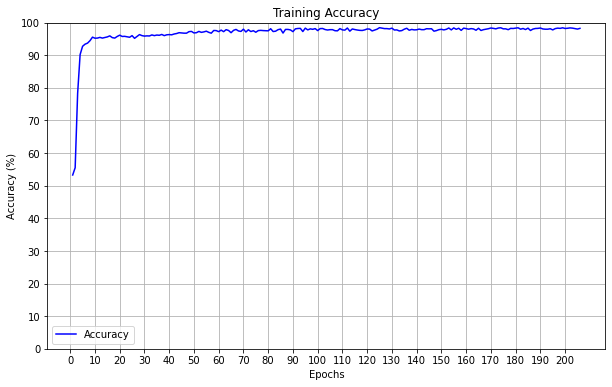

In [84]:
plt.figure(figsize=(10, 6)) 

# Obtain the accuracy values from the training history
accuracy_values = history.history['acc']

# Convert decimal accuracy values to percentage
accuracy_percentage = [acc * 100 for acc in accuracy_values]

# Plot the accuracy graph
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_percentage, 'b', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')  # Update y-axis label

plt.ylim(0, 100)  # Set y-axis limit to 0-100

plt.xticks(range(0, len(accuracy_values) + 1, 10))
plt.legend()
plt.grid(True)
plt.yticks(range(0, 101, 10))  # Update y-axis ticks to show percentage
plt.show()


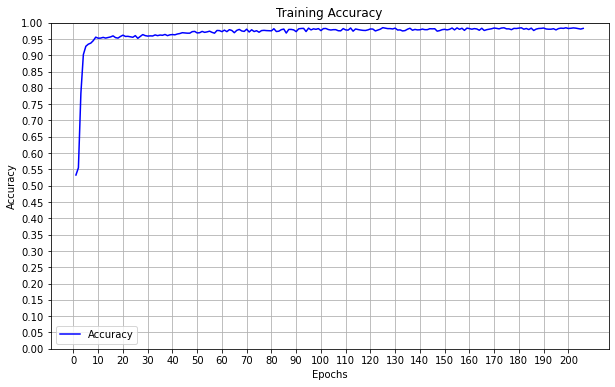

In [81]:
plt.figure(figsize=(10, 6)) 

# Obtain the loss values from the training history
loss_values = history.history['acc']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.xlim(0, len(loss_values) + 1)
# plt.ylim(0, max(loss_values) + 100)
# plt.yticks([i / 2 for i in range(0, 21)])
# plt.ylim(0.5, 1)

plt.xticks(range(0, len(loss_values) + 1, 10))


plt.legend()
plt.grid(True)
plt.yticks([i / 20 for i in range(21)])
plt.show()


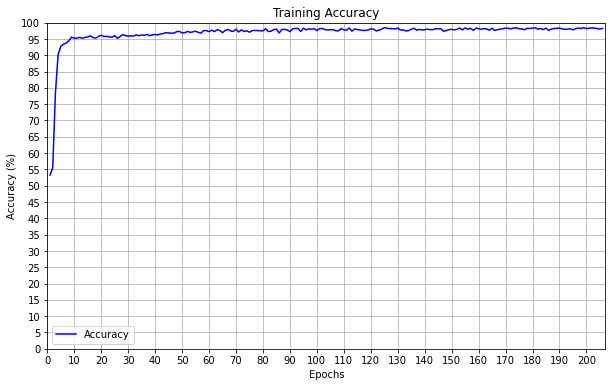

In [88]:
plt.figure(figsize=(10, 6)) 

# Obtain the accuracy values from the training history
accuracy_values = history.history['acc']

# Convert decimal accuracy values to percentage
accuracy_percentage = [acc * 100 for acc in accuracy_values]

# Plot the accuracy graph
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_percentage, 'b', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')  # Update y-axis label

plt.xlim(0, len(accuracy_values) + 1) 
plt.ylim(0, 100)  # Set y-axis limit to 0-100

plt.xticks(range(0, len(accuracy_values) + 1, 10))
plt.legend()
plt.grid(True)
plt.yticks(range(0, 101, 5))  

plt.show()

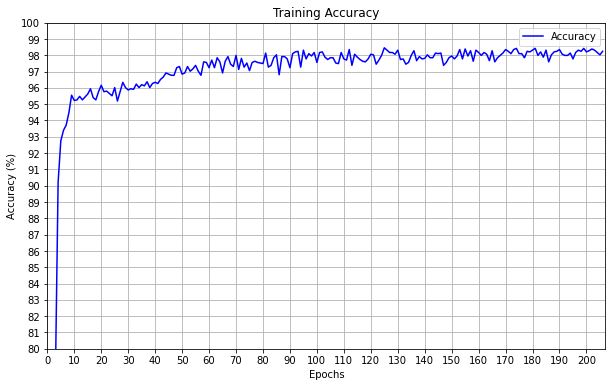

In [91]:
plt.figure(figsize=(10, 6)) 

# Obtain the accuracy values from the training history
accuracy_values = history.history['acc']

# Convert decimal accuracy values to percentage
accuracy_percentage = [acc * 100 for acc in accuracy_values]

# Plot the accuracy graph
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_percentage, 'b', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.xlim(0, len(accuracy_values) + 1) 
plt.ylim(80, 100)  # Set y-axis limit to start from 50%

plt.xticks(range(0, len(accuracy_values) + 1, 10))
plt.legend()
plt.grid(True)
plt.yticks(range(80, 101, 1))  # Start y-axis ticks from 50%

plt.show()


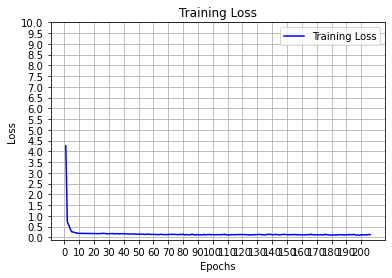

In [41]:
# Obtain the loss values from the training history
loss_values = history.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, len(loss_values) + 10)
# plt.ylim(0, max(loss_values) + 0.1)
# plt.ylim(0, 10)
plt.grid(True)
# Set the x-axis ticks to display every 10 epochs
plt.xticks(range(0, len(loss_values) + 1, 10))
# plt.yticks(range(0, 11, 1))
plt.yticks([i / 2 for i in range(0, 21)])

plt.legend()
plt.show()

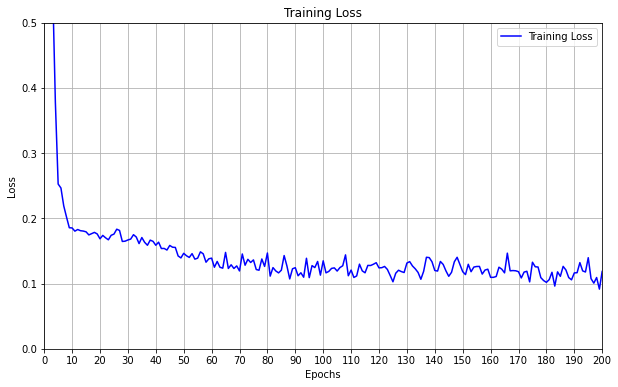

In [62]:
plt.figure(figsize=(10, 6)) 

# Obtain the loss values from the training history
loss_values = history.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, len(loss_values) + 10)
# plt.ylim(0, max(loss_values) + 0.1)
plt.ylim(0, 0.5)
plt.xlim(0, 200)

plt.grid(True)
# Set the x-axis ticks to display every 10 epochs
# plt.xticks(range(0, len(loss_values) + 1, 10))
# plt.xticks(range(0, min(len(loss_values) + 1, 106), 10))
plt.xticks(range(0, 205 + 1, 10))
# Draw grid lines on the y-axis at every 0.1 loss interval
plt.yticks([i / 10 for i in range(6)])
# plt.yticks(range(0, 11, 1))
# plt.yticks([i / 2 for i in range(0, 1)])

plt.legend()
plt.show()

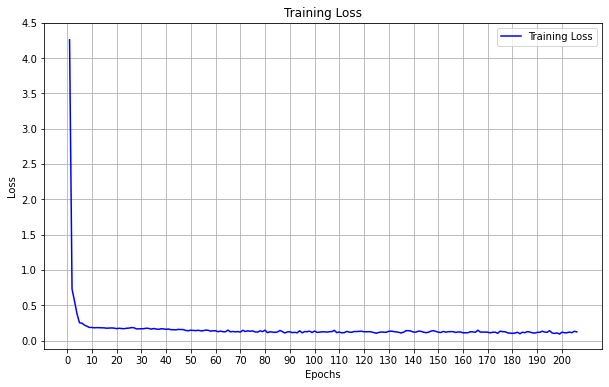

In [64]:
plt.figure(figsize=(10, 6)) 

# Obtain the loss values from the training history
loss_values = history.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, len(loss_values) + 10)
# plt.ylim(0, max(loss_values) + 0.1)
# plt.ylim(0, 5)
# plt.xlim(0, 200)

plt.grid(True)
# Set the x-axis ticks to display every 10 epochs
# plt.xticks(range(0, len(loss_values) + 1, 10))
# plt.xticks(range(0, min(len(loss_values) + 1, 106), 10))
plt.xticks(range(0, 205 + 1, 10))

# plt.yticks(range(0, 11, 1))
plt.yticks([i / 2 for i in range(0, 10)])

plt.legend()
plt.show()

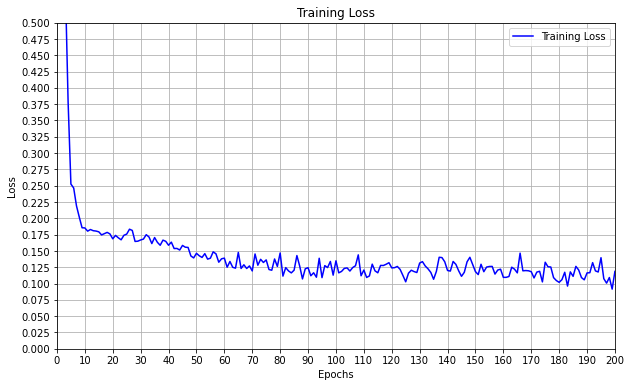

In [60]:
plt.figure(figsize=(10, 6)) 

# Obtain the loss values from the training history
loss_values = history.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.5)
plt.xlim(0, 200)

plt.grid(True)

# Set the x-axis ticks to display every 10 epochs
plt.xticks(range(0, 205 + 1, 10))

# Draw grid lines on the y-axis at every 0.025 loss interval
plt.yticks([i / 40 for i in range(21)])

plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


This is after 206 epochs

In [92]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test1, Y_test_categorical)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-17 21:23:14.093283: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/AddN_1' id:221 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-17 21:23:14.779630: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once

Test Loss: 0.5272811370511209
Test Accuracy: 0.91935486


In [93]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0020.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.20539276119201413
Test accuracy: 0.9516129


In [94]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0010.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.22760833203792571
Test accuracy: 0.9419355


In [95]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0030.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.2330517621770982
Test accuracy: 0.9516129


In [96]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0040.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.19937594571421224
Test accuracy: 0.9516129


In [97]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0050.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.2974220398693315
Test accuracy: 0.9354839


In [98]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0060.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.34152707308530805
Test accuracy: 0.9


In [99]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0070.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.25242207156073665
Test accuracy: 0.9419355


In [100]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0080.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.3969361144208139
Test accuracy: 0.9387097


In [101]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0090.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.3836431186285711
Test accuracy: 0.9354839


In [102]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0100.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.39201546407515003
Test accuracy: 0.91612905


In [103]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0110.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.42350005714162703
Test accuracy: 0.9387097


In [104]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0120.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.31857247669850625
Test accuracy: 0.93225807


In [105]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0130.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.4968700933840967
Test accuracy: 0.91612905


In [106]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0140.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.44989565831999623
Test accuracy: 0.91935486


In [107]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0150.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.5763060754345309
Test accuracy: 0.89354837


In [108]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0160.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.5280564439152517
Test accuracy: 0.90645164


In [109]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0170.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.5839556150138379
Test accuracy: 0.90967745


In [110]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0180.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.7842919784207498
Test accuracy: 0.91935486


In [111]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0190.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.4949991182694512
Test accuracy: 0.91612905


In [112]:
# Load checkpoint weights
checkpoint_path = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/weights_epoch_0200.ckpt"  # Specify the correct path
model.load_weights(checkpoint_path)


# Evaluate the model
loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.4462757577819209
Test accuracy: 0.91935486


In [131]:
import matplotlib.cm as cm

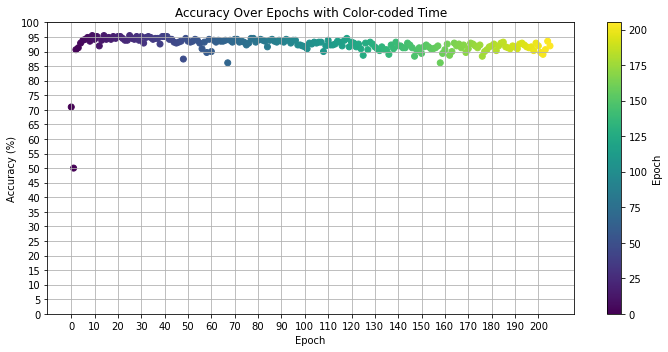

In [132]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_accuracies = {}  # Use a dictionary to store epoch accuracies

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch accuracy in the dictionary if it's higher
    if epoch_number not in epoch_accuracies or accuracy > epoch_accuracies[epoch_number]:
        epoch_accuracies[epoch_number] = accuracy * 100

epochs = sorted(epoch_accuracies.keys())  # Sort the epochs
accuracies = [epoch_accuracies[epoch] for epoch in epochs]  # Get accuracies corresponding to sorted epochs

# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(10, 5))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, accuracies, c=colormap(norm(epochs)), marker='o', label='Accuracy vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

plt.title('Accuracy Over Epochs with Color-coded Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(0, max(epochs) + 1, 10))
plt.yticks(range(0, 101, 5))

plt.tight_layout()
plt.show()

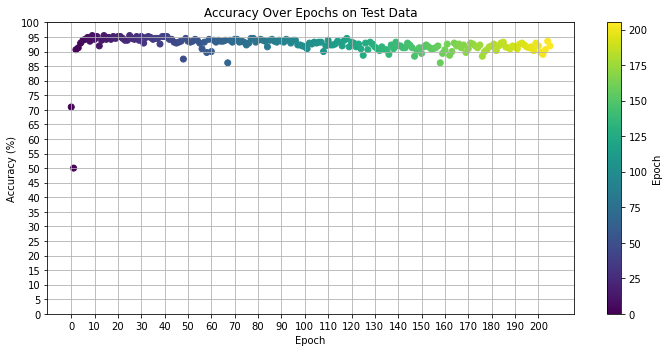

In [133]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_accuracies = {}  # Use a dictionary to store epoch accuracies

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch accuracy in the dictionary if it's higher
    if epoch_number not in epoch_accuracies or accuracy > epoch_accuracies[epoch_number]:
        epoch_accuracies[epoch_number] = accuracy * 100

epochs = sorted(epoch_accuracies.keys())  # Sort the epochs
accuracies = [epoch_accuracies[epoch] for epoch in epochs]  # Get accuracies corresponding to sorted epochs


# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(10, 5))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, accuracies, c=colormap(norm(epochs)), marker='o', label='Accuracy vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

plt.title('Accuracy Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(0, max(epochs) + 1, 10))
plt.yticks(range(0, 101, 5))

plt.tight_layout()
plt.show()

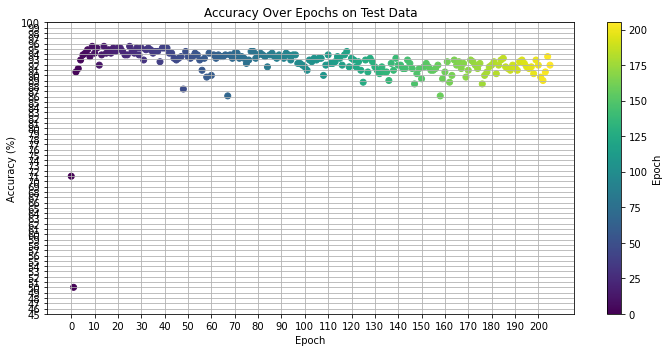

In [139]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_accuracies = {}  # Use a dictionary to store epoch accuracies

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch accuracy in the dictionary if it's higher
    if epoch_number not in epoch_accuracies or accuracy > epoch_accuracies[epoch_number]:
        epoch_accuracies[epoch_number] = accuracy * 100

epochs = sorted(epoch_accuracies.keys())  # Sort the epochs
accuracies = [epoch_accuracies[epoch] for epoch in epochs]  # Get accuracies corresponding to sorted epochs




# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(10, 5))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, accuracies, c=colormap(norm(epochs)), marker='o', label='Accuracy vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

plt.title('Accuracy Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(45, 100)

plt.grid(True)
plt.xticks(range(0, max(epochs) + 1, 10))
plt.yticks(range(45, 101, 1))

plt.tight_layout()
plt.show()

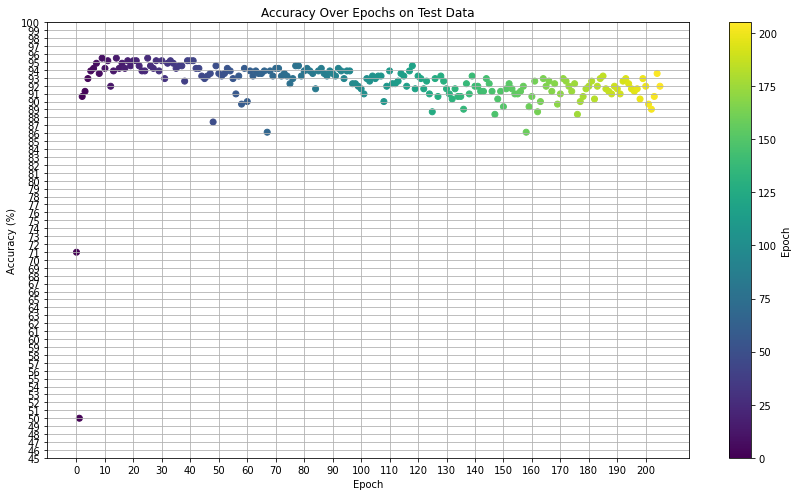

In [140]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_accuracies = {}  # Use a dictionary to store epoch accuracies

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch accuracy in the dictionary if it's higher
    if epoch_number not in epoch_accuracies or accuracy > epoch_accuracies[epoch_number]:
        epoch_accuracies[epoch_number] = accuracy * 100

epochs = sorted(epoch_accuracies.keys())  # Sort the epochs
accuracies = [epoch_accuracies[epoch] for epoch in epochs]  # Get accuracies corresponding to sorted epochs




# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(12, 7))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, accuracies, c=colormap(norm(epochs)), marker='o', label='Accuracy vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

plt.title('Accuracy Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(45, 100)

plt.grid(True)
plt.xticks(range(0, max(epochs) + 1, 10))
plt.yticks(range(45, 101, 1))

plt.tight_layout()
plt.show()

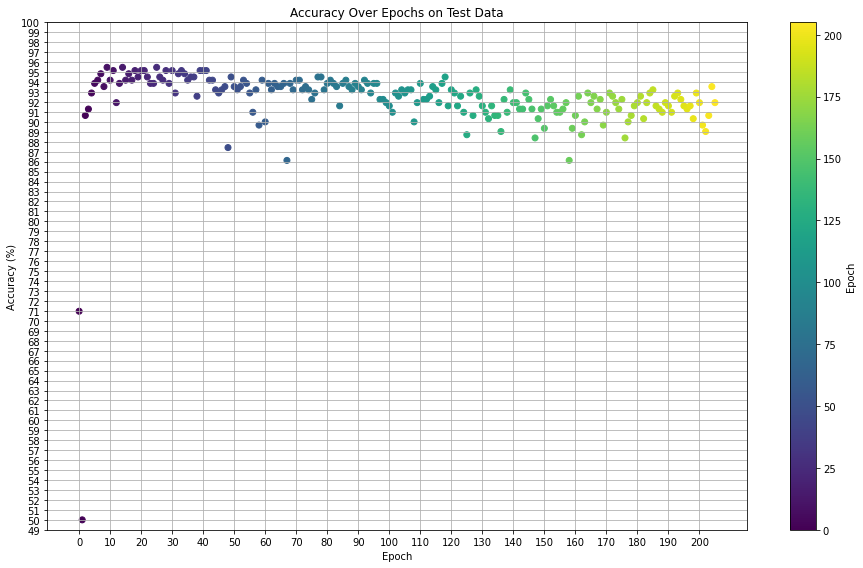

In [141]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_accuracies = {}  # Use a dictionary to store epoch accuracies

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch accuracy in the dictionary if it's higher
    if epoch_number not in epoch_accuracies or accuracy > epoch_accuracies[epoch_number]:
        epoch_accuracies[epoch_number] = accuracy * 100

epochs = sorted(epoch_accuracies.keys())  # Sort the epochs
accuracies = [epoch_accuracies[epoch] for epoch in epochs]  # Get accuracies corresponding to sorted epochs




# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(13, 8))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, accuracies, c=colormap(norm(epochs)), marker='o', label='Accuracy vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

plt.title('Accuracy Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(49, 100)

plt.grid(True)
plt.xticks(range(0, max(epochs) + 1, 10))
plt.yticks(range(49, 101, 1))

plt.tight_layout()
plt.show()

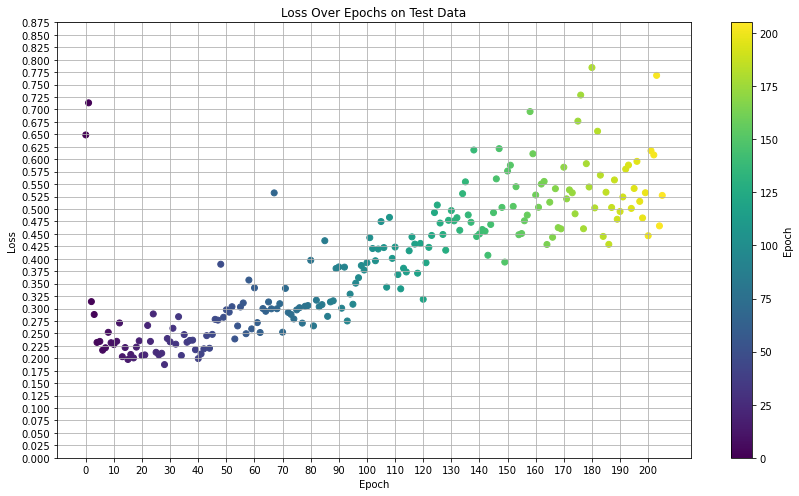

In [137]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_losses = {}  # Use a dictionary to store epoch losses

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch loss in the dictionary if it's lower
    if epoch_number not in epoch_losses or loss < epoch_losses[epoch_number]:
        epoch_losses[epoch_number] = loss

epochs = sorted(epoch_losses.keys())  # Sort the epochs
losses = [epoch_losses[epoch] for epoch in epochs]  # Get losses corresponding to sorted epochs


# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(12, 7))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, losses, c=colormap(norm(epochs)), marker='o', label='Loss vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

# plt.plot(losses, marker='o')
plt.title('Loss Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 0.5)
# plt.xlim(0, 200)

plt.grid(True)

# Set the x-axis ticks to display every 10 epochs
plt.xticks(range(0, 205 + 1, 10))

# Draw grid lines on the y-axis at every 0.025 loss interval
plt.yticks([i / 40 for i in range(36)])


plt.tight_layout()
plt.show()

***********************************************************************************

## Saving the X train and X test, Y train and Y_test into pixel files for any further evaluation on the same data

In [143]:
import os
import pickle

pickle_folder = 'classifcation_neww_cnonc_datafiles'

# Create the folder if it doesn't exist
if not os.path.exists(pickle_folder):
    os.makedirs(pickle_folder)

pickle_file_path = os.path.join(pickle_folder, 'X_test1.pickle')

if os.path.exists(pickle_file_path):
    # Load the pickled data
    with open(pickle_file_path, 'rb') as f:
        X_test1 = pickle.load(f)
else:

    # Save X_test1 to the pickle file
    with open(pickle_file_path, 'wb') as f:
        pickle.dump(X_test1, f)

In [144]:
if not os.path.exists(pickle_folder):
    os.makedirs(pickle_folder)

pickle_file_path = os.path.join(pickle_folder, 'Y_test_categorical.pickle')

if os.path.exists(pickle_file_path):
    # Load the pickled data
    with open(pickle_file_path, 'rb') as f:
        Y_test_categorical = pickle.load(f)
else:

    # Save Y_test_categorical to the pickle file
    with open(pickle_file_path, 'wb') as f:
        pickle.dump(Y_test_categorical, f)

In [145]:
if not os.path.exists(pickle_folder):
    os.makedirs(pickle_folder)

pickle_file_path = os.path.join(pickle_folder, 'X_train1.pickle')

if os.path.exists(pickle_file_path):
    # Load the pickled data
    with open(pickle_file_path, 'rb') as f:
        X_train1 = pickle.load(f)
else:

    # Save X_train1 to the pickle file
    with open(pickle_file_path, 'wb') as f:
        pickle.dump(X_train1, f)

In [146]:
if not os.path.exists(pickle_folder):
    os.makedirs(pickle_folder)

pickle_file_path = os.path.join(pickle_folder, 'Y_train_categorical.pickle')

if os.path.exists(pickle_file_path):
    # Load the pickled data
    with open(pickle_file_path, 'rb') as f:
        Y_train_categorical = pickle.load(f)
else:

    # Save Y_train_categorical to the pickle file
    with open(pickle_file_path, 'wb') as f:
        pickle.dump(Y_train_categorical, f)

************************************************************

# Testing

In [142]:
sample_index = 32  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.9960997  0.00390029]]


/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-18 13:00:59.318896: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Softmax' id:111 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*******************************************************

## Below is testing on previously trained model when the unbalanced class issue wasn't handled and when there wasn't a stratified split that was performed.

In [49]:
sample_index = 32  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-16 22:20:19.043820: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_29/kernel/Assign' id:2220 op device:{requested: '', assigned: ''} def:{{{node dense_29/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_29/kernel, dense_29/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Prediction: [[0.46135503 0.53864497]]


In [66]:
sample_index = 32  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-16 22:38:38.327428: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_38/Softmax' id:3058 op device:{requested: '', assigned: ''} def:{{{node dense_38/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_38/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Prediction: [[0.22848763 0.7715124 ]]


In [50]:
sample_index = 101  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.46016902 0.5398309 ]]


In [67]:
sample_index = 101  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[1.0706241e-04 9.9989295e-01]]


In [51]:
sample_index = 500  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.46420574 0.53579426]]


In [68]:
sample_index = 500  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.92517054 0.07482944]]


In [52]:
sample_index = 2  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.46180707 0.53819287]]


In [69]:
sample_index = 2  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.02281775 0.9771822 ]]


In [53]:
sample_index = 1000  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.4596822  0.54031783]]


In [70]:
sample_index = 1000  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.00100118 0.9989988 ]]


In [56]:
sample_index = 1827  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.46183792 0.5381621 ]]


In [71]:
sample_index = 1827  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.00521687 0.9947831 ]]


In [57]:
sample_index = 2  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.46180707 0.53819287]]


In [72]:
sample_index = 2  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0.02281775 0.9771822 ]]


In [58]:
sample_index = 32  # Replace with the index of the desired sample

sample = np.expand_dims(X_train[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[9.8371515e-17 1.0000000e+00]]


In [73]:
sample_index = 32  # Replace with the index of the desired sample

sample = np.expand_dims(X_train[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0. 1.]]


In [60]:
sample_index = 4000 # Replace with the index of the desired sample

sample = np.expand_dims(X_train[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[2.568827e-18 1.000000e+00]]


In [74]:
sample_index = 4000 # Replace with the index of the desired sample

sample = np.expand_dims(X_train[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[0. 1.]]


## Testing (when previously had used one neural network for all 4 predictions)

In [34]:
sample_index = 15  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[-13.584453   -28.08273      0.31239802   0.67342305]]


In [35]:
print(Y_test[15])

[-16.88556385 -25.87927952   0.           1.        ]


In [36]:
sample_index = 32  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[ -1.052757  -33.802345    0.5072885   0.6418066]]


In [37]:
print(Y_test[32])

[  2.17081855 -30.74475237   0.           0.        ]


In [5]:
sess.close()
tf.reset_default_graph()


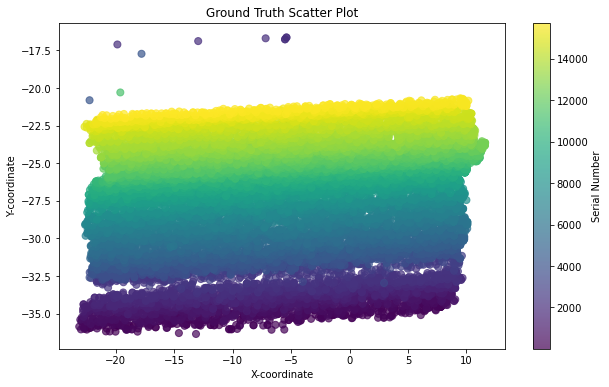

In [34]:
import matplotlib.pyplot as plt

x_values = data_df['x_actual']
y_values = data_df['y_actual']
serial_numbers = data_df['Serial_no']

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, c=serial_numbers, cmap='viridis', s=50, alpha=0.7)

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Ground Truth Scatter Plot')

# Add a colorbar legend
cbar = plt.colorbar()
cbar.set_label('Serial Number')

plt.show()
